In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import nu, fu
from pandas import DataFrame
import numpy as np
import pandas as pd
import re

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df', scene_stats_df='scene_stats_df')

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/scene_stats_df.pkl.



# Build a Model to Predict Adherence to SALT


#### Create a data frame with all the feature columns

In [4]:

scene_stats_df = data_frames_dict['scene_stats_df']
scene_stats_df.drop(columns=['is_cluster2'], inplace=True)
# print(sorted(scene_stats_df.columns))

# Ensure that you have no duplicate columns in the data frame
mask_series = scene_stats_df.columns.duplicated(keep='first')
if mask_series.any():
    print(scene_stats_df.shape)
    print(scene_stats_df.columns[mask_series].tolist())
    
    # Drop the duplicate columns using the mask
    scene_stats_df.drop(scene_stats_df.columns[mask_series], axis='columns', inplace=True)
    print(scene_stats_df.shape)

In [ ]:

frvrs_logs_df = data_frames_dict['frvrs_logs_df']
print(frvrs_logs_df.shape) # (829116, 125)

In [36]:

# Add the target variable values back into scene stats
if (target_variable not in scene_stats_df.columns) and (target_variable in frvrs_logs_df.columns):
    for (session_uuid, scene_id, target_variable_value), _ in frvrs_logs_df.groupby(fu.scene_groupby_columns+[target_variable]):
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (scene_stats_df[cn] == eval(cn))
        scene_stats_df.loc[mask_series, target_variable] = target_variable_value

In [135]:

# Remove columns to get the best input features
target_variable = 'adherence_to_salt'
input_features = list(set(scene_stats_df.columns) - set([
    target_variable, 'session_uuid', 'measure_of_right_ordering', 'stills_value', 'walkers_value', 'actual_distracted_delta', 'measure_of_ideal_ordering',
    'actual_engagement_distance', 'actual_ideal_delta', 'measure_of_distracted_ordering', 'ideal_engagement_distance', 'distracted_engagement_distance'
]))

In [136]:

# Keep track of the target variable and input features columns
columns_list = [target_variable] + input_features
scene_history_df = scene_stats_df[columns_list].dropna(axis='columns', how='all').dropna(axis='index', how='any')
print(scene_history_df.shape) # (611, 46)

(616, 39)



#### One-hot encode it

In [137]:

# Analyze the data frame for input features that need to be encoded
column_descriptions_df = nu.get_column_descriptions(scene_history_df.sample(min(2000, scene_history_df.shape[0])))
mask_series = (column_descriptions_df.dtype == 'object')
df = column_descriptions_df[mask_series]
display(df)
encodeable_columns = list(set(df.column_name) - set([target_variable]))

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
38,scene_type,object,0,2,0,False,Orientation,Triage,NaN


In [138]:

# One-hot encode the input features columns in the one-hot encoded data frame
def one_hot_encode(df, columns):
    '''
    One-hot encodes the given columns in the given data frame.
    
    Args:
        df: A data frame.
        columns: A list of column names to encode.
    
    Returns:
        A data frame with the encoded columns.
    '''
    
    dummies = pd.get_dummies(df[columns], dummy_na=True)
    df = pd.concat([df, dummies], axis='columns').drop(columns, axis='columns')
    
    return df
ascii_regex = re.compile('[^a-z0-9]+')
one_hot_encode_df = one_hot_encode(scene_history_df, encodeable_columns)
one_hot_encode_df = one_hot_encode_df.rename(columns={cn: ascii_regex.sub('_', cn.lower()).strip('_') for cn in one_hot_encode_df.columns})
columns_list = [cn for cn in one_hot_encode_df.columns if any(map(lambda x: cn.endswith(x), ['_null', '_nan']))]
print(columns_list)
# df = one_hot_encode_df.sample(min(12, one_hot_encode_df.shape[0])).dropna(axis='columns', how='all').T
# display(df.sample(min(20, df.shape[0])).sort_index())

['scene_type_nan']


In [139]:

# Demonstrate that you have no duplicate columns in the data frame
mask_series = one_hot_encode_df.columns.duplicated()
if mask_series.any(): print(one_hot_encode_df.columns[mask_series])

In [140]:

# Analyze the input features
# one_hot_column_descriptions_df = nu.get_column_descriptions(one_hot_encode_df.sample(min(2000, one_hot_encode_df.shape[0])))
# display(one_hot_column_descriptions_df.sample(min(20, one_hot_column_descriptions_df.shape[0])).sort_index())


#### Train a classifier on it

In [141]:

# Train a classifier on the patient history data frame
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and test sets
df = one_hot_encode_df.dropna(axis='index', how='any')
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target_variable], axis='columns'),
    df[target_variable],
    test_size=0.25,
    random_state=42
)

# Convert the uint8 features to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Convert the boolean labels to integers (True to 1, False to 0)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [142]:

# Create a random forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = rf_classifier.predict(X_test)
rf_accuracy = np.mean(y_pred == y_test)

# Calculate the feature importances
feature_importances = rf_classifier.feature_importances_

# Create a data frame to store the feature names and feature importances
feature_importances_df = pd.DataFrame()
feature_importances_df['feature_name'] = df.drop(target_variable, axis='columns').columns
feature_importances_df['feature_importance'] = feature_importances

In [143]:

# Train a logistic regression classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = lr_classifier.predict(X_test)
lr_accuracy = np.mean(y_pred == y_test)

# Get the coefficients of the logistic regression model
feature_coefficients = lr_classifier.coef_[0]

# Create a data frame to store the feature names and feature coefficients
feature_coefficients_df = pd.DataFrame()
feature_coefficients_df['feature_name'] = df.drop(target_variable, axis='columns').columns
feature_coefficients_df['feature_coefficient'] = feature_coefficients
feature_coefficients_df['absolute_coefficient'] = feature_coefficients_df.feature_coefficient.map(lambda x: abs(x))

In [144]:

from sklearn.inspection import permutation_importance

# Train a histogram-based gradient boosting classifier
hgb_classifier = HistGradientBoostingClassifier().fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = hgb_classifier.predict(X_test)
hgb_accuracy = np.mean(y_pred == y_test)

# Calculate the feature importances using the Permutation Importance algorithm
hgb_permutation_importances = permutation_importance(hgb_classifier, X_test, y_test)

In [145]:

# Create a data frame to store the feature names and feature coefficients
hgb_permutation_importances_df = pd.DataFrame()
hgb_permutation_importances_df['feature_name'] = df.drop(target_variable, axis='columns').columns
for fn in dir(hgb_permutation_importances):
    
    # Iterate through each column
    if (fn == 'importances'):
        for i, importances in enumerate([hgb_permutation_importances.importances[:, i] for i in range(hgb_permutation_importances.importances.shape[1])]):
            hgb_permutation_importances_df[f'importance{i}'] = importances
    
    else: hgb_permutation_importances_df[fn] = eval(f'hgb_permutation_importances.{fn}')


#### Evaluate the accuracies and importances

In [146]:

# Print the accuracies
print('RF Accuracy:', rf_accuracy)
print('LR Accuracy:', lr_accuracy)
print('HGB Accuracy:', hgb_accuracy)

RF Accuracy: 0.987012987012987
LR Accuracy: 0.8311688311688312
HGB Accuracy: 0.974025974025974


In [169]:

# Display the feature importances data frame
df = feature_importances_df.sort_values('feature_importance', ascending=False).head(10)
rf_importances_list = df.feature_name.tolist()
display(df)

,feature_name,feature_importance
32,patient_sort_turbulence,0.209403
34,patient_sort_complexity,0.179924
17,combo_complexity,0.081557
4,injury_severity_turbulence,0.067961
23,combo_turbulence,0.055387
7,last_still_engagement,0.046338
15,patient_count,0.045845
9,first_engagement,0.035938
16,injury_severity_complexity,0.029040
27,teleport_count,0.016865


In [170]:

# Display the feature coefficients data frame
columns_list = ['feature_name', 'feature_coefficient']
df = feature_coefficients_df.sort_values('absolute_coefficient', ascending=False)[columns_list].head(10)
lr_importances_list = df.feature_name.tolist()
display(df)

,feature_name,feature_coefficient
1,total_actions,-0.000196
9,first_engagement,0.000078
7,last_still_engagement,-0.000053
35,scene_start,-0.000044
2,triage_time,0.000028
33,first_treatment,-0.000019
36,scene_end,-0.000016
5,voice_capture_count,-0.000007
28,time_to_last_hemorrhage_controlled,-0.000007
3,pulse_taken_count,0.000003


In [171]:

# Display the permutation importances data frame
columns_list = ['feature_name', 'importances_mean']
df = hgb_permutation_importances_df.drop(columns_list, axis='columns')
max_importance = df.max().max()
columns_list += df.columns[df.eq(max_importance).any()].tolist()[:7-len(columns_list)]
df = hgb_permutation_importances_df.sort_values('importances_mean', ascending=False)[columns_list].head(10)
hbg_importances_list = df.feature_name.tolist()
display(df)

,feature_name,importances_mean,importance4
32,patient_sort_turbulence,0.212987,0.227273
34,patient_sort_complexity,0.142857,0.155844
7,last_still_engagement,0.097403,0.103896
6,injury_correctly_treated_count,0.010390,0.006494
9,first_engagement,0.003896,0.000000
1,total_actions,0.002597,0.000000
4,injury_severity_turbulence,0.002597,0.000000
16,injury_severity_complexity,0.001299,-0.006494
0,scene_id,0.000000,0.000000
29,walk_command_count,0.000000,0.000000


In [180]:

from itertools import combinations

importances_lists = [rf_importances_list, lr_importances_list, hbg_importances_list]
for list_pair in combinations(importances_lists, 2):
    print(set(list_pair[0]).intersection(set(list_pair[1])))

{'first_engagement', 'last_still_engagement'}
{'last_still_engagement', 'injury_severity_complexity', 'first_engagement', 'patient_sort_turbulence', 'injury_severity_turbulence', 'patient_sort_complexity'}
{'first_engagement', 'last_still_engagement', 'total_actions'}


In [173]:

set(rf_importances_list).intersection(set(lr_importances_list)).intersection(set(hbg_importances_list))

{'first_engagement', 'last_still_engagement'}


### Visualize Feature Importance


Adapted from https://www.researchgate.net/publication/225402919_De-standardization_of_Family-Life_Trajectories_of_Young_Adults_A_Cross-National_Comparison_Using_Sequence_Analysis

The concept of ‘turbulence’ is well known in hydrodynamics, where it refers to aproperty of ﬂow. A ﬂow is turbulent if its speed and direction are unstable, i.e., changes rapidly and irregularly. Categorical time series like patient engagement order by SORT also consist of ﬂows of events or states in time. We will consider series that have many distinct states and many state changes as being more turbulent than series with fewer distinct states and/or fewer state changes. This implies that the substantive meaning of the various states involved does not play a role in determining the amount of turbulence of the categorical time series.

**Measuring turbulence**: Different measures exist to quantify turbulence in categorical time series. One common approach is the sequence turbulence measure proposed by Elzinga and Liefbroer (2007), which considers both the number of distinct subsequences and the variance of state durations.

**Interpretation**: High turbulence indicates a series with numerous distinct states and frequent transitions, suggesting unpredictability and complexity. Low turbulence signifies a series with fewer distinct states and stable transitions, reflecting order and simplicity.

**Contextual interpretation**: While turbulence measures the formal characteristics of state changes, it's crucial to consider the meaningful interpretation within your specific domain. For example, high turbulence in patient engagement might suggest erratic behavior, while in customer purchase histories, it might reflect diverse interests.

**Limitations**: Turbulence measures don't directly capture the meaning of states or the underlying processes generating the series. Therefore, they should be used in conjunction with other methods that consider domain-specific knowledge.

In [174]:

import matplotlib.pyplot as plt

def visualize_feature_importances(feature_name, feature_description=None):
    if feature_description is None: feature_description = ' '.join([w.title() for w in feature_name.split('_')])
    
    # Create the scatter plot (mappable object)
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.cm.coolwarm
    scatter = ax.scatter(scene_stats_df['measure_of_right_ordering'], scene_stats_df[feature_name], c=scene_stats_df['adherence_to_salt'], cmap=cmap)
    
    # Add labels and title
    ax.set_xlabel('Measure of Right Ordering')
    ax.set_ylabel(feature_description)
    ax.set_title(f'Scatter Plot of Measure of Right Ordering vs {feature_description} Colored by Adherence to SALT')
    
    # Add the colorbar, referencing the scatter plot
    plt.colorbar(scatter, label='Adherence to SALT')  # Use the scatter object as the mappable
    
    # Annotate with Spearman's Rank Correlation Coefficient
    s_str = nu.get_spearman_rho_value_latex(scene_stats_df['measure_of_right_ordering'], scene_stats_df[feature_name])
    text_tuple = ax.text(0.05, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
    
    # Annotate with Coefficient of Determination
    s_str = nu.get_r_squared_value_latex(scene_stats_df['measure_of_right_ordering'], scene_stats_df[feature_name])
    text_tuple = ax.text(0.05, 0.85, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
    
    # Annotate label centroids with cluster labels
    columns_list = ['measure_of_right_ordering', feature_name]
    X = scene_stats_df[columns_list].values
    labels = scene_stats_df['adherence_to_salt'].values
    for i in [False, True]:
        arr = X[labels == i]
        mask = ~np.isnan(arr).any(axis=1)
        ax.annotate(f'Adherence to\nSALT {i}', np.mean(arr[mask], axis=0), fontsize=10, ha='center')

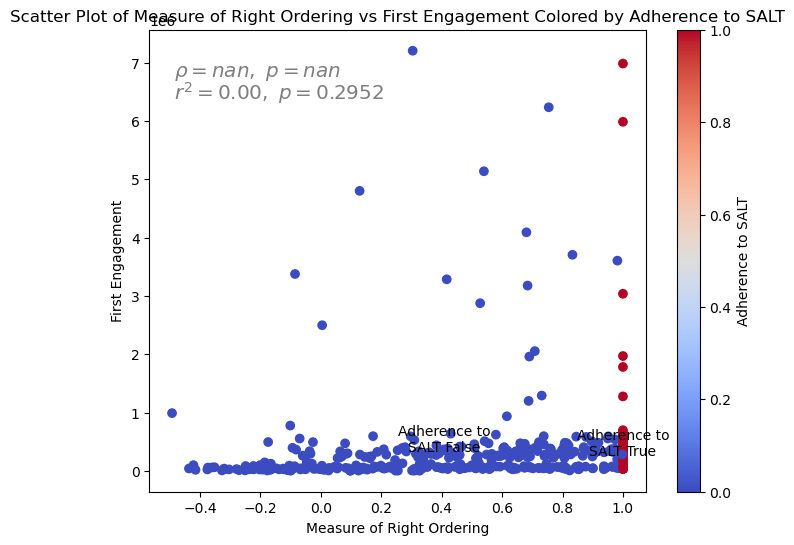

In [177]:

visualize_feature_importances('first_engagement')

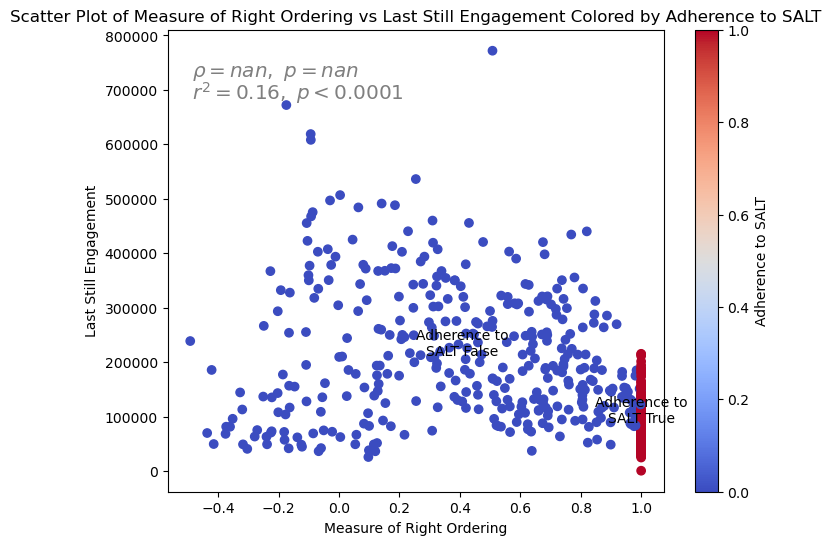

In [178]:

visualize_feature_importances('last_still_engagement')

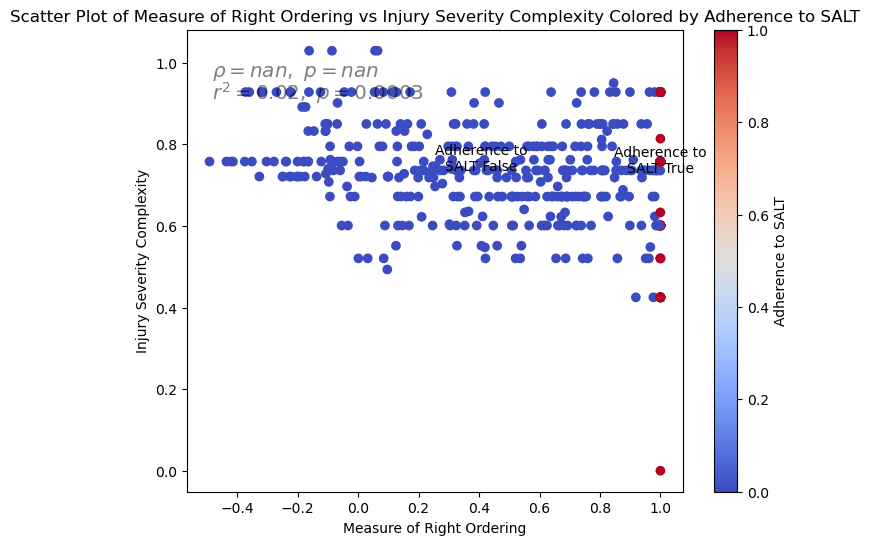

In [181]:

visualize_feature_importances('injury_severity_complexity')

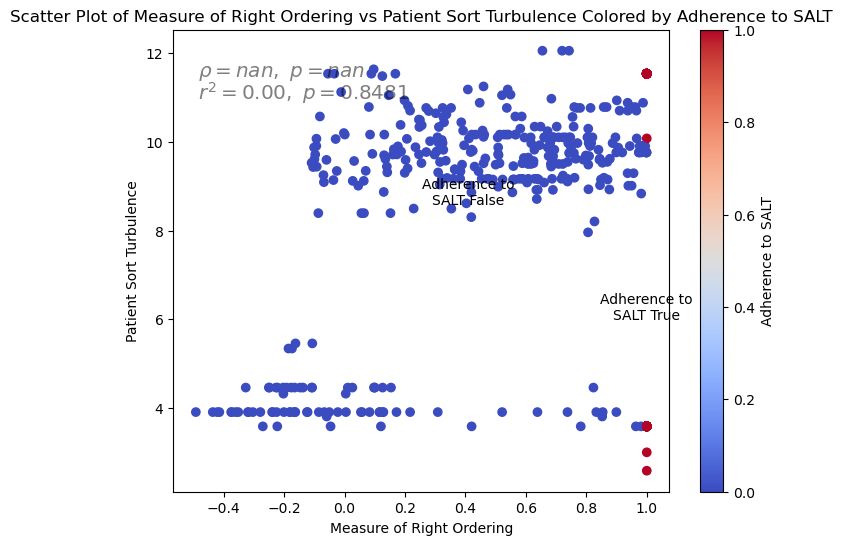

In [176]:

visualize_feature_importances('patient_sort_turbulence')

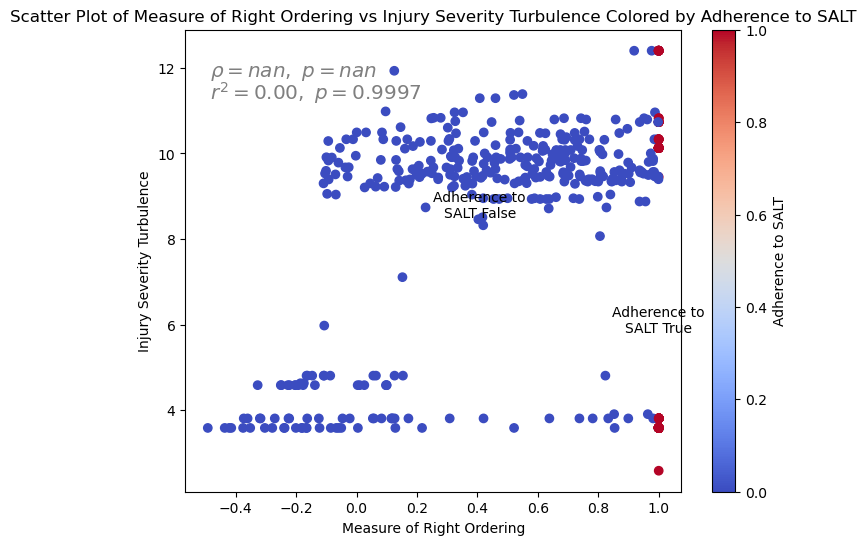

In [182]:

visualize_feature_importances('injury_severity_turbulence')

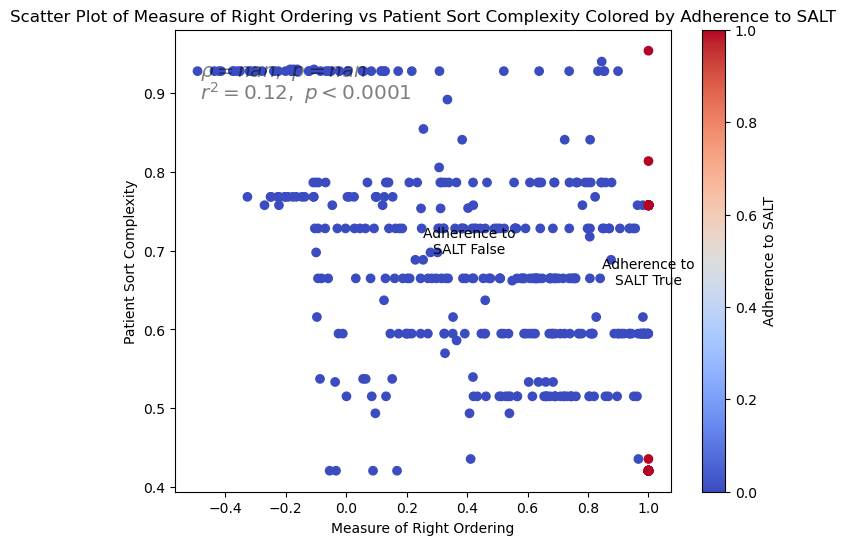

In [183]:

visualize_feature_importances('patient_sort_complexity')

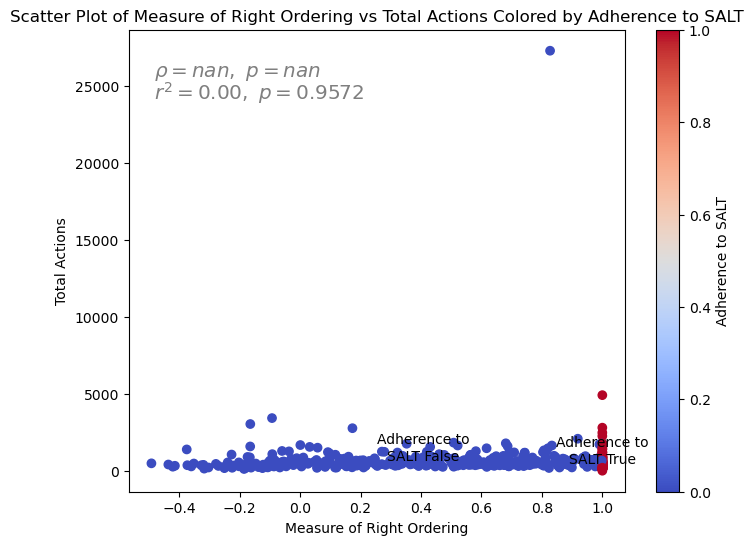

In [184]:

visualize_feature_importances('total_actions')

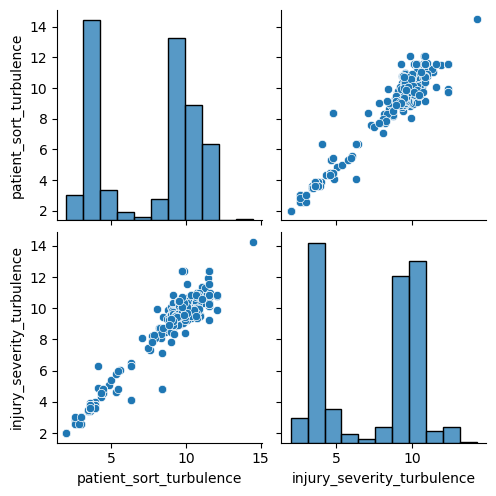

In [186]:

import seaborn as sns

columns_list = ['patient_sort_turbulence', 'injury_severity_turbulence']
PairGrid_obj = sns.pairplot(scene_stats_df[columns_list])


## Perform a sample inference

In [187]:

# Display the one-hot encoded sample
input_encode_df = one_hot_encode_df.sample(1)
input_encode_idx = input_encode_df.index.item()
print(input_encode_idx)
print(input_encode_df.shape)
mask_series = (input_encode_df.T[input_encode_idx] == 0)
df = input_encode_df.T[~mask_series]
enc_idx_list = df.index.tolist()
display(df)

441
(1, 41)


,441
scene_id,1
total_actions,908
triage_time,495581
pulse_taken_count,25
injury_severity_turbulence,9.823769
voice_capture_count,30
injury_correctly_treated_count,6
last_still_engagement,350327.0
first_engagement,438003.0
is_a_one_triage_file,True


In [189]:

# Add the target variable values back into logs
if (target_variable not in frvrs_logs_df.columns) and (target_variable in scene_stats_df.columns):
    for (session_uuid, scene_id, target_variable_value), _ in scene_stats_df.groupby(fu.scene_groupby_columns+[target_variable]):
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
        frvrs_logs_df.loc[mask_series, target_variable] = target_variable_value

In [190]:

# Display the FRVRS Logs sample
mask_series = (scene_stats_df.index == input_encode_idx)
df = scene_stats_df[mask_series]
mask_series = (frvrs_logs_df.session_uuid == df.session_uuid.squeeze()) & (frvrs_logs_df.scene_id == df.scene_id.squeeze())
df = frvrs_logs_df[mask_series]
print(df.shape)
cn_set = set()
for cn in frvrs_logs_df.columns:
    for enc_idx in enc_idx_list:
        if enc_idx.startswith(cn): cn_set.add(cn)
columns_list = [target_variable] + list(cn_set)
display(df[columns_list].drop_duplicates().sort_values(columns_list).T)

(991, 126)


,735450,735453,735461,735475,735467,735460,735446
adherence_to_salt,False,False,False,False,False,False,False
patient_sort,still,waver,walker,NaN,NaN,NaN,NaN
scene_id,1,1,1,1,1,1,1
logger_version,1.0,1.0,1.0,1.0,1.0,1.0,1.0
scene_type,Triage,Triage,Triage,Triage,Triage,Triage,Triage
is_a_one_triage_file,True,True,True,True,True,True,True
injury_severity,NaN,NaN,NaN,high,medium,low,NaN


In [191]:

# Display the scene history sample
mask_series = (scene_history_df.index == input_encode_idx)
df = scene_history_df[mask_series]
print(df.shape)
cn_set = set()
for cn in scene_history_df.columns:
    for enc_idx in enc_idx_list:
        if enc_idx.startswith(cn): cn_set.add(cn)
columns_list = [target_variable] + list(cn_set - set([target_variable]))
display(df[columns_list].T)

(1, 39)


,441
adherence_to_salt,False
scene_id,1
total_actions,908
triage_time,495581
scene_type,Triage
pulse_taken_count,25
injury_severity_turbulence,9.823769
injury_correctly_treated_count,6
voice_capture_count,30
last_still_engagement,350327.0


In [192]:

# Convert the input features to a NumPy array
input_features_array = np.array(input_encode_df.drop(target_variable, axis='columns').values)
actual_target_value = input_encode_df[target_variable].squeeze()

In [193]:

# Predict the target value
predicted_target_value = sorted(
    [(c, p) for c, p in zip(lr_classifier.classes_, lr_classifier.predict_proba(input_features_array)[0])], key=lambda x: x[1], reverse=True
)[0][0]
print(f'LR: predicted: {[False, True][predicted_target_value]}, actual: {actual_target_value}')

LR: predicted: False, actual: False


In [194]:

# Predict the target value
predicted_target_value = sorted(
    [(c, p) for c, p in zip(rf_classifier.classes_, rf_classifier.predict_proba(input_features_array)[0])], key=lambda x: x[1], reverse=True
)[0][0]
print(f'RF: predicted: {[False, True][predicted_target_value]}, actual: {actual_target_value}')

RF: predicted: False, actual: False


In [195]:

# Predict the target value
predicted_target_value = sorted(
    [(c, p) for c, p in zip(hgb_classifier.classes_, hgb_classifier.predict_proba(input_features_array)[0])], key=lambda x: x[1], reverse=True
)[0][0]
print(f'HGB: predicted: {[False, True][predicted_target_value]}, actual: {actual_target_value}')

HGB: predicted: False, actual: False
